In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
import tikzplotlib
import seaborn as sns

import json
from datetime import datetime

In [3]:
projects_df = pd.read_csv('/root/data/projects.csv',
                         parse_dates=['project_created_at', 'project_last_pushed_at', 'project_updated_at'])

packages_df = pd.read_csv('/root/data/packages_0_499.csv')
geiger_df = pd.read_csv('/root/data/geiger/geiger_findings_0_499.csv')

vet_df = pd.read_csv('/root/data/linters/vet_findings_0_499.csv')
gosec_df = pd.read_csv('/root/data/linters/gosec_findings_0_499.csv')

grep_df = pd.read_csv('/root/data/linters/grep_findings_0_499.csv')
ast_df = pd.read_csv('/root/data/ast/ast_findings_0_499.csv')
function_df = pd.read_csv('/root/data/ast/functions_0_499.csv')
statement_df = pd.read_csv('/root/data/ast/statements_0_499.csv')

labeled_usages_app_df = pd.read_csv('/root/data/labeled-dataset/sampled_usages_app.csv')
labeled_usages_std_df = pd.read_csv('/root/data/labeled-dataset/sampled_usages_std.csv')

In [4]:
def with_thousands_comma(n):
    return '{:,}'.format(n)

# Figures included in the thesis document

## Chapter 2

## Chapter 3

## Chapter 4

In [189]:
unique_unsafe_usages_count = geiger_df.drop_duplicates(subset=['column', 'line_number', 'file_name', 'package_dir', 
                                  'package_import_path', 'module_version'])\
    ['text'].count()

print("Unique unsafe usages in the data set: {}".format(unique_unsafe_usages_count))

Unique unsafe usages in the data set: 199496


**Distribution of unsafe by token type**

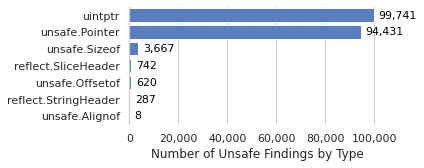

In [7]:
data = packages_df\
    .drop_duplicates(subset=['import_path', 'dir', 'module_path', 'module_version']).dropna()\
    .loc[:,['package_geiger_unsafe_pointer_sum', 'package_geiger_unsafe_sizeof_sum', 'package_geiger_unsafe_offsetof_sum',
           'package_geiger_unsafe_alignof_sum', 'package_geiger_slice_header_sum', 'package_geiger_string_header_sum',
           'package_geiger_uintptr_sum']]\
    .rename(columns={'package_geiger_unsafe_pointer_sum': 'unsafe.Pointer', 'package_geiger_unsafe_sizeof_sum': 'unsafe.Sizeof',
                    'package_geiger_unsafe_offsetof_sum': 'unsafe.Offsetof', 'package_geiger_unsafe_alignof_sum': 'unsafe.Alignof',
                    'package_geiger_slice_header_sum': 'reflect.SliceHeader', 'package_geiger_string_header_sum': 'reflect.StringHeader',
                    'package_geiger_uintptr_sum': 'uintptr'})\
    .sum()\
    .sort_values(ascending=False)

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 2.5))

# Plot the distribution among types
sns.set_color_codes("muted")
g = sns.barplot(data.values, data.index, color="b")

# Add values next to the bars
for p in ax.patches:
    ax.annotate("{}".format(with_thousands_comma(int(p.get_width()))), (p.get_width(), p.get_y() + p.get_height() / 2.0),
                ha='left', va='center', fontsize=11, color='black', xytext=(5, 0),
                textcoords='offset points')
#_ = g.set_xlim(0, 120000) #To make space for the annotations

# Add a legend and informative axis label
ax.set(ylabel="", xlabel="Number of Unsafe Findings by Type")
sns.despine(bottom=True)

# Add thousands separator to x axis
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.savefig('/root/data/figures/thesis/chapter4/distribution-unsafe-types.pdf')
plt.show()

**Import depth of unsafe packages**

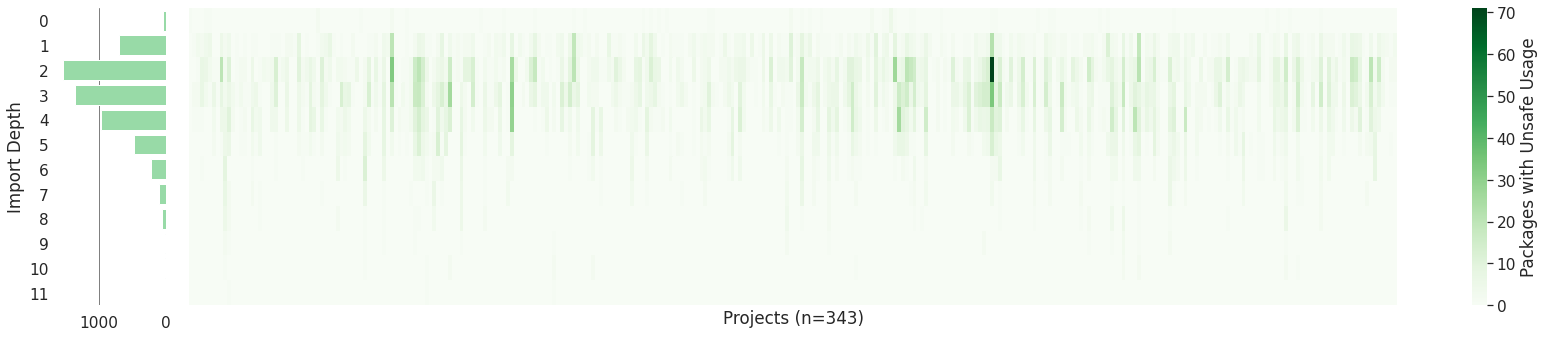

In [356]:
## number of unsafe packages (without std) over hop count

df = packages_df\
    [(packages_df['is_standard']==False)&(packages_df['package_unsafe_sum']>0)]\
    .groupby(['project_name', 'package_hop_count'])['package_unsafe_sum'].count()\
    .unstack().fillna(0).T

distribution_df = packages_df\
    [(packages_df['is_standard']==False)&(packages_df['package_unsafe_sum']>0)]\
    .groupby('package_hop_count')['package_unsafe_sum'].count().T

sns.set(style="white")
sns.set(font_scale=1.4)

# create plot setup
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(24, 5), gridspec_kw={'width_ratios': [1, 14]})
fig.subplots_adjust(wspace=0)

# plot heatmap
sns.heatmap(df, ax=axs[1], cmap='Greens', cbar_kws={'label': 'Packages with Unsafe Usage'})

# plot distribution
sns.set_color_codes("pastel")
sns.barplot(distribution_df.values, distribution_df.index, orient='h', color="g", ax=axs[0])
axs[0].invert_xaxis()
axs[0].set_facecolor("white")
axs[0].xaxis.grid(color="gray")

# labeling
for item in axs[1].get_yticklabels():
    item.set_rotation(0)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set(ylabel="", xlabel="Projects (n={})".format(packages_df['project_name'].nunique()))
axs[0].set(ylabel="Import Depth", xlabel="")
sns.despine(bottom=True, left=True)

plt.tight_layout()
plt.savefig('/root/data/figures/thesis/chapter4/unsafe-import-depth.pdf', bbox_inches='tight')
plt.show()

**Example code snippets for label classes in data set**

In [31]:
labels = labeled_usages_app_df['label'].unique()

seen_labels2 = set()

for label in sorted(labels):
    example = labeled_usages_app_df[labeled_usages_app_df['label']==label].iloc[3]
    print("// {}, {}\n{}\n".format(example['label'], example['label2'], example['text']))
    seen_labels2.add(example['label2'])
    
print("missing: {}".format(set(labeled_usages_app_df['label2'].unique()) - seen_labels2))

// cast-basic, efficiency
out.TimeoutSeconds = (*int32)(unsafe.Pointer(in.TimeoutSeconds))

// cast-bytes, serialization
return (*(*[SizeofTcTbfQopt]byte)(unsafe.Pointer(x)))[:]

// cast-header, efficiency
retVal = append(retVal, *(*[]uint8)(unsafe.Pointer(hdr)))

// cast-pointer, serialization
return unsafe.Pointer(ptr), newUnfolderArrIfc()

// cast-struct, efficiency
out.Configuration = (*runtime.Unknown)(unsafe.Pointer(in.Configuration))

// definition, serialization
rtype    unsafe.Pointer

// delegate, serialization
func (encoder *dynamicEncoder) Encode(ptr unsafe.Pointer, stream *Stream) {

// memory-access, serialization
func (encoder *dereferenceEncoder) IsEmbeddedPtrNil(ptr unsafe.Pointer) bool {

// pointer-arithmetic, layout
unaligned := brokenUnaligned && uintptr(unsafe.Pointer(&value[0]))&3 != 0

// syscall, no-gc
n, _, errno := syscall.Syscall(syscall.SYS_RECVMSG, s, uintptr(unsafe.Pointer(h)), uintptr(flags))

// unused, unused
func (encoder emptyArrayEncoder) Encode(ptr

**Influence of Popularity**

In [59]:
df1 = pd.merge(geiger_df, packages_df, how='left', 
                left_on=['package_import_path', 'project_name', 'package_dir'], 
                right_on=['import_path', 'project_name', 'dir'])

df2 = df1\
    [df1['is_standard']==False]\
    .groupby('project_name')\
    .agg(unsafe_count=pd.NamedAgg(column='project_name', aggfunc='count'))

unsafe_by_project_features_df = pd.merge(df2, projects_df, how='left', on='project_name')

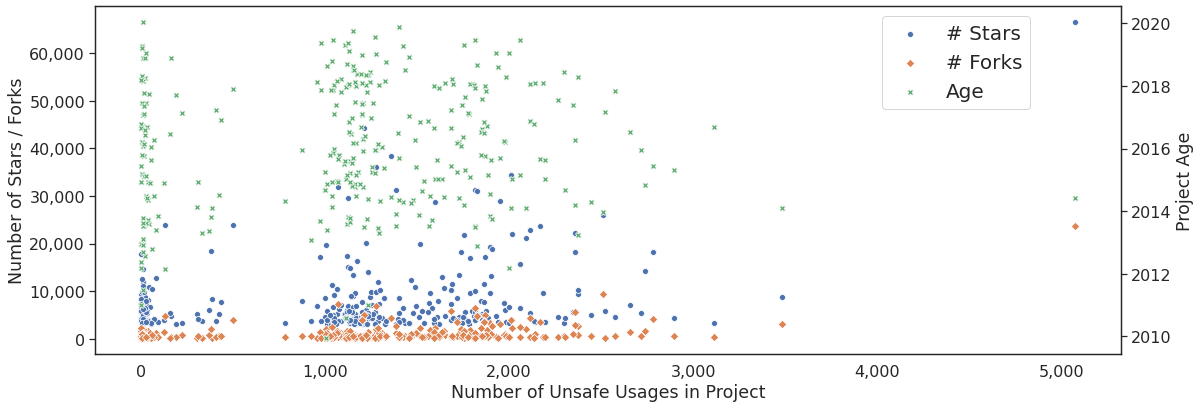

In [393]:
sns.set_color_codes("pastel")
sns.set(style='white', font_scale=1.45)

fig, ax = plt.subplots(figsize=(17, 6))

sns.scatterplot(data=unsafe_by_project_features_df, x='unsafe_count', y='project_number_of_stars', marker='o', ax=ax)
sns.scatterplot(data=unsafe_by_project_features_df, x='unsafe_count', y='project_number_of_forks', marker='D', ax=ax)

ax2 = ax.twinx()

sns.scatterplot(data=[], ax=ax2)
sns.scatterplot(data=[], ax=ax2)
sns.scatterplot(data=unsafe_by_project_features_df, x='unsafe_count', y='project_created_at', marker='X', ax=ax2)

# Add legend and axis labels
fig.legend(['# Stars', '# Forks', 'Age'], loc='upper right', bbox_to_anchor=(0.85, 0.93), fontsize=20)
ax.set_xlabel('Number of Unsafe Usages in Project')
ax.set_ylabel('Number of Stars / Forks')
ax2.set_ylabel('Project Age')

# Add thousands separator to axes
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.savefig('/root/data/figures/thesis/chapter4/correlation-popularity.pdf')

In [174]:
unsafe_by_project_features_df[unsafe_by_project_features_df['unsafe_count']>3500]

,project_name,unsafe_count,project_rank,project_github_clone_url,project_number_of_stars,project_number_of_forks,project_github_id,project_revision,project_created_at,project_last_pushed_at,project_updated_at,project_size,project_checkout_path,project_uses_modules,project_root_module
207,kubernetes/kubernetes,5074,2,https://github.com/kubernetes/kubernetes.git,66512,23806,20580498,fb9e1946b0af89998b3e366d49399f6365c94c56,2014-06-06 22:56:04+00:00,2020-05-28 19:09:23+00:00,2020-05-28 18:55:28+00:00,918555,/root/download/kubernetes/kubernetes,True,k8s.io/kubernetes


**Change of unsafe usage over time**

Manually add date column and sort ascending by date.

In [372]:
packages_df\
    [packages_df['package_geiger_unsafe_pointer_sum']>0]\
    .groupby('module_path')['module_version'].nunique().sort_values()[-20:]

module_path
github.com/go-redis/redis               6
github.com/peterh/liner                 7
github.com/opencontainers/runc          7
github.com/prometheus/client_golang     7
github.com/vishvananda/netlink          7
github.com/mailru/easyjson              7
github.com/gorilla/websocket            8
github.com/gocql/gocql                  8
github.com/syndtr/goleveldb             8
github.com/nsf/termbox-go               9
github.com/gogo/protobuf               10
github.com/golang/protobuf             11
k8s.io/apiextensions-apiserver         13
github.com/docker/docker               18
golang.org/x/tools                     21
k8s.io/client-go                       22
golang.org/x/crypto                    23
golang.org/x/net                       25
k8s.io/apimachinery                    27
golang.org/x/sys                       67
Name: module_version, dtype: int64

<Figure size 432x288 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

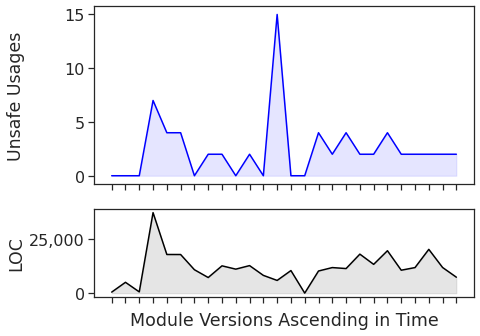

In [58]:
def plot_module_unsafe_change(module_path, color):
    plt.clf()
    module_path_short = module_path.split('/')[-1]

    unsafe_df = packages_df\
        [packages_df['module_path']==module_path]\
        .groupby(['module_version', 'project_name'])['package_geiger_unsafe_pointer_sum'].sum()\
        .groupby('module_version').max()\
        .sort_index()
    loc_df = packages_df\
        [packages_df['module_path']==module_path]\
        .groupby(['module_version', 'project_name'])['loc'].sum()\
        .groupby('module_version').max()\
        .sort_index()
    
    #print(df.index.values)

    sns.set(style='white', font_scale=1.45)
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize = (7,5), gridspec_kw={'height_ratios': [2, 1]})
    sns.lineplot(data=unsafe_df, ax=axs[0], color='blue')
    sns.lineplot(data=loc_df, ax=axs[1], color='black')

    # shading
    l1 = axs[0].lines[0]
    l2 = axs[1].lines[0]
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    x2 = l2.get_xydata()[:,0]
    y2 = l2.get_xydata()[:,1]
    axs[0].fill_between(x1, y1, color='blue', alpha=0.10)
    axs[1].fill_between(x2, y2, color='black', alpha=0.10)
    
    # formatting
    axs[0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    axs[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # labeling
    axs[0].xaxis.set_major_formatter(ticker.NullFormatter())
    plt.xlabel('Module Versions Ascending in Time')
    plt.setp(axs[0], ylabel='Unsafe Usages')
    plt.setp(axs[1], ylabel='LOC')
    fig.align_ylabels(axs[:])

    plt.tight_layout()
    #plt.show()
    plt.savefig("/root/data/figures/thesis/chapter4/unsafe-over-time-{}.pdf".format(module_path_short))


modules = [('golang.org/x/sys', 'black'),
           ('github.com/golang/protobuf', 'black'),
           ('k8s.io/apimachinery', 'black'),
           ('github.com/docker/docker', 'black'),
          ]

for module, color in modules:
    plot_module_unsafe_change(module, color)


In [34]:
packages_df.columns

Index(['name', 'import_path', 'dir', 'is_standard', 'is_dep_only',
       'number_of_go_files', 'loc', 'byte_size', 'module_path',
       'module_version', 'module_registry', 'module_is_indirect',
       'project_name', 'package_hop_count', 'package_unsafe_sum',
       'package_geiger_unsafe_pointer_sum',
       'package_geiger_unsafe_pointer_variable',
       'package_geiger_unsafe_pointer_parameter',
       'package_geiger_unsafe_pointer_assignment',
       'package_geiger_unsafe_pointer_call',
       'package_geiger_unsafe_pointer_other',
       'package_geiger_unsafe_sizeof_sum',
       'package_geiger_unsafe_sizeof_variable',
       'package_geiger_unsafe_sizeof_parameter',
       'package_geiger_unsafe_sizeof_assignment',
       'package_geiger_unsafe_sizeof_call',
       'package_geiger_unsafe_sizeof_other',
       'package_geiger_unsafe_offsetof_sum',
       'package_geiger_unsafe_offsetof_variable',
       'package_geiger_unsafe_offsetof_parameter',
       'package_geiger_unsa

**Stats about unique analyzed packages**

In [201]:
df = packages_df\
    .drop_duplicates(subset=['import_path', 'dir', 'module_path', 'module_version'])

packages_count = df['name'].count()
unsafe_packages_count = df[df['package_unsafe_sum']>0]['name'].count()

print("{} of {} ({:.2%}) transitively imported packages use unsafe".format(unsafe_packages_count, packages_count,
                                                                    unsafe_packages_count/packages_count))

3388 of 62025 (5.46%) transitively imported packages use unsafe


In [208]:
df['number_of_go_files'].describe()

count    62036.000000
mean         4.431379
std         11.354799
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1223.000000
Name: number_of_go_files, dtype: float64

**Unsafe packages at level 1**

In [225]:
df = packages_df\
    [packages_df['package_unsafe_sum']>0]\
    .drop_duplicates(subset=['import_path', 'dir', 'module_path', 'module_version'])

depth_1_count = df[df['package_hop_count']==1]['name'].count()
total_count = df['name'].count()

print("{} out of {} ({:.2%}) unsafe packages are imported at depth 1.".format(depth_1_count, total_count, depth_1_count/total_count))

496 out of 3388 (14.64%) unsafe packages are imported at depth 1.


**Unsafe packages at level 0**

In [223]:
df = packages_df\
    [packages_df['package_unsafe_sum']>0]\
    .drop_duplicates(subset=['import_path', 'dir', 'module_path', 'module_version'])

depth_0_count = df[df['package_hop_count']==0]['name'].count()
total_count = df['name'].count()

print("{} out of {} ({:.2%}) unsafe packages are imported at depth 0.".format(depth_0_count, total_count, depth_0_count/total_count))

51 out of 3388 (1.51%) unsafe packages are imported at depth 0.


## Chapter 5

## Chapter 6

## Chapter 7

## Table A.1 Projects

In [198]:
def thousands_formatter(number):
    return "{:,}".format(number)

def monospace_formatter(text):
    return "\\texttt{{{}}}".format(text)

def length_cap_formatter(text):
    if len(text) > 24:
        text = "{}\\ldots".format(text[:25])
    return text.replace("_", "\\_")

def status_formatter(status):
    if status == 'included':
        return ""
    elif status == 'labeled':
        return "*"
    elif status == 'no-modules':
        return "\\textit{nm}"
    elif status == 'build-failed':
        return "\\textit{bf}"
    else:
        return "??"

In [199]:
analyzed_projects = packages_df['project_name'].unique()
projects_in_labeled_dataset = labeled_usages_app_df['project_name'].unique()
projects_with_errors = ['tinygo-org/tinygo', 'henrylee2cn/pholcus', 'therecipe/qt', 'google/gvisor', 
                        'chai2010/advanced-go-programming-book', 'ehang-io/nps', 'rancher/k3s']

def check_status(project):
    if project in projects_in_labeled_dataset:
        return 'labeled'
    elif project in analyzed_projects:
        return 'included'
    elif project in projects_with_errors:
        return 'build-failed'
    else:
        return 'no-modules'

df = projects_df.loc[:,['project_name', 'project_number_of_stars', 'project_number_of_forks', 
                   'project_revision']]

df['project_revision'] = df.apply(lambda x: x['project_revision'][:10], axis=1)
df['status'] = df.apply(lambda x: check_status(x['project_name']), axis=1)
df.index = df.index + 1

df

,project_name,project_number_of_stars,project_number_of_forks,project_revision,status
1,golang/go,72988,10460,6bf2eea62a,no-modules
2,kubernetes/kubernetes,66512,23806,fb9e1946b0,labeled
3,moby/moby,57189,16540,763f9e799b,no-modules
4,avelino/awesome-go,54733,7267,3e27d63fe2,no-modules
5,gohugoio/hugo,44317,5049,6a3e89743c,included
...,...,...,...,...,...
496,disintegration/imaging,3089,271,879073f233,included
497,gogf/gf,3087,450,269378aa0d,included
498,googleforgames/agones,3082,356,d017250c43,included
499,kubernetes-sigs/external-dns,3078,926,deaeca2ab1,included


In [200]:
latex = df.to_latex(header=['Name', 'Stars', 'Forks', 'Revision', 'Included'], 
    index=True, escape=False, formatters={
        'project_name': length_cap_formatter,
        'project_number_of_stars': thousands_formatter, 
        'project_number_of_forks': thousands_formatter, 
        'project_revision': monospace_formatter,
        'status': status_formatter})

lines = latex.split("\n")
lines = lines[4:-3]

for i in range(0, 250):
    lines.insert(1 + i*3, '\\rowcolor{verylightgray}')

print("\n".join(lines))

1   &                          golang/go & 72,988 & 10,460 &  \texttt{6bf2eea62a} &  \textit{nm} \\
\rowcolor{verylightgray}
2   &              kubernetes/kubernetes & 66,512 & 23,806 &  \texttt{fb9e1946b0} &            * \\
3   &                          moby/moby & 57,189 & 16,540 &  \texttt{763f9e799b} &  \textit{nm} \\
\rowcolor{verylightgray}
4   &                 avelino/awesome-go & 54,733 &  7,267 &  \texttt{3e27d63fe2} &  \textit{nm} \\
5   &                      gohugoio/hugo & 44,317 &  5,049 &  \texttt{6a3e89743c} &              \\
\rowcolor{verylightgray}
6   &                      gin-gonic/gin & 38,459 &  4,441 &  \texttt{5e40c1d49c} &              \\
7   &                       fatedier/frp & 36,184 &  6,860 &  \texttt{2406ecdfea} &              \\
\rowcolor{verylightgray}
8   &    astaxie/build-web-applica\ldots & 34,787 &  9,516 &  \texttt{606abd586a} &  \textit{nm} \\
9   &                          gogs/gogs & 34,522 &  4,030 &  \texttt{7e99a6ce42} &              \\
